When creating a Machine Learning or AI application, we always want the most accurate predictions possible. Model optimization can give us better results if we are willing to spend the time. There are many tools and techniques to optimize models for Machine Learning and Artificial Intelligence solutions. One way to optimize your model is to tune the hyperparameters. This can give you a much higher score if done correctly. I will show you how to use 2 of the most popular tools, GridSearchCV and CrossValidation. These tools are very flexible, you can use almost any model in them. I will start with a simple one - RandomForestClassifier. The datasource I will use is an open source dataset containing credit card transactions with fraud/not fraud as the label. This dataset is heavily imbalanced, so I will also include some techniques on how to deal with this complex issue.

In [1]:
# Import Libraries
# try some of these ideas: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
import numpy as np
import pandas as pd
import datetime

import os 
import time
import matplotlib as mpl                                                                                             
if os.environ.get('DISPLAY','') == '':                                                                               
    print('no display found. Using non-interactive Agg backend')                                                     
    mpl.use('Agg')                                                                    
        
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling as pp
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
import zipfile

import tensorflow as tf

no display found. Using non-interactive Agg backend


Including a timer for benchmarking

In [2]:
class MyTimer():
    # usage:
    #with MyTimer():                            
    #    rf.fit(X_train, y_train)
    
    def __init__(self):
        self.start = time.time()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        end = time.time()
        runtime = end - self.start
        msg = 'The function took {time} seconds to complete'
        print(msg.format(time=runtime))

In [3]:
def display_metrics(model_name, train_features, test_features, train_label, test_label, pred):
    try:
        print(model_name.score(test_features, test_label)) 
        print("Accuracy score (training): {0:.3f}".format(model_name.score(train_features, train_label))) 
        print("Accuracy score (validation): {0:.3f}".format(model_name.score(test_features, test_label))) 
    except Exception as e:
        print("error")  
    try:
        print(pd.Series(model_name.feature_importances_, index=train_features.columns[:]).nlargest(10).plot(kind='barh')) 
    except Exception as e:
        print("error")  
        
    print("Confusion Matrix:")
    tn, fp, fn, tp = confusion_matrix(test_label, pred).ravel()
    total = tn+ fp+ fn+ tp 
    print("false positive pct:",(fp/total)*100) 
    print("tn", " fp", " fn", " tp") 
    print(tn, fp, fn, tp) 
    print(confusion_matrix(test_label, pred)) 
    print("Classification Report") 
    print(classification_report(test_label, pred))
    print("Specificity =", tn/(tn+fp))
    print("Sensitivity =", tp/(tp+fn))
    return tn, fp, fn, tp

In [4]:
def visualize(Actual, Pred, Algo):
    #Confusion Matrix
    cnf_matrix=metrics.confusion_matrix(Actual, Pred) #

    #Visualize confusion matrix using heat map

    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix: '+Algo, y=1.1) 
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [5]:
def auc_roc_metrics(model, test_features, test_labels, algo): # model object, features, actual labels, name of algorithm
    # useful for imbalanced data
    ns_probs = [0 for _ in range(len(test_labels))]
    # predict probabilities
    model_probs = model.predict_proba(test_features)
    # keep probabilities for the positive outcome only
    n = model.predict_proba(test_features).shape[1]-1
    model_probs = model_probs[:, n]  
    model_auc = auc_roc_metrics_plots(model_probs, ns_probs, test_labels, algo) 
    return model_auc

In [6]:
def auc_roc_metrics_plots(model_probs, ns_probs, test_labels, algo):
    
    # calculate scores
    ns_auc = roc_auc_score(test_labels, ns_probs) # no skill
    model_auc = round(roc_auc_score(test_labels, model_probs), 4)
    
    # summarize scores
    print('%10s : ROC AUC=%.3f' % ('No Skill',ns_auc))
    print('%10s : ROC AUC=%.3f' % (algo,model_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(test_labels, ns_probs)
    # NameError: name 'ns_probs' is not defined
    model_fpr, model_tpr, _ = roc_curve(test_labels, model_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(model_fpr, model_tpr, marker='.', label='%s (area = %0.2f)' % (algo, model_auc))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    pyplot.title('Receiver Operating Characteristic curve')
    # show the plot
    pyplot.show()
    return model_auc

In [7]:
def CalcPct(df,title):
    unique_elements, counts_elements = np.unique(df, return_counts=True)
    calc_pct = round(counts_elements[1]/(counts_elements[0]+counts_elements[1]) * 100,6)
    print(title)
    print(np.asarray((unique_elements, counts_elements)))
    return calc_pct

In [8]:
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

In [9]:
print(datetime.datetime.now())
verbose = 0
# alternate location: https://datahub.io/machine-learning/creditcard/r/creditcard.csv
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

2020-06-22 09:52:46.661826


In [10]:
#try some data cleansing

temp_df = df.copy()
temp_df = temp_df.drop(['Time'], axis=1)
temp_df['Log_Amount'] = np.log(temp_df.pop('Amount')+0.001)
df = temp_df.copy()

Look at cross correlations between features. Most models will be fine with collinearity, but good to know this in any case. Most of my input is numerical, and my label is binary classification, so I can choose the Anova or Kendall's method. I will try the Kendall tau-b method first. This method will sort the 2 columns and compare if the X is always > or < Y. If so, the tau-b value will be 1.

Some key points to remember:
Kendall’s Tau: Calculations based on concordant and discordant pairs. Insensitive to error. P values are more accurate with smaller sample sizes. Good resource can be found here: https://online.stat.psu.edu/stat509/node/158/

This image shows which method you should choose based on your dataset:
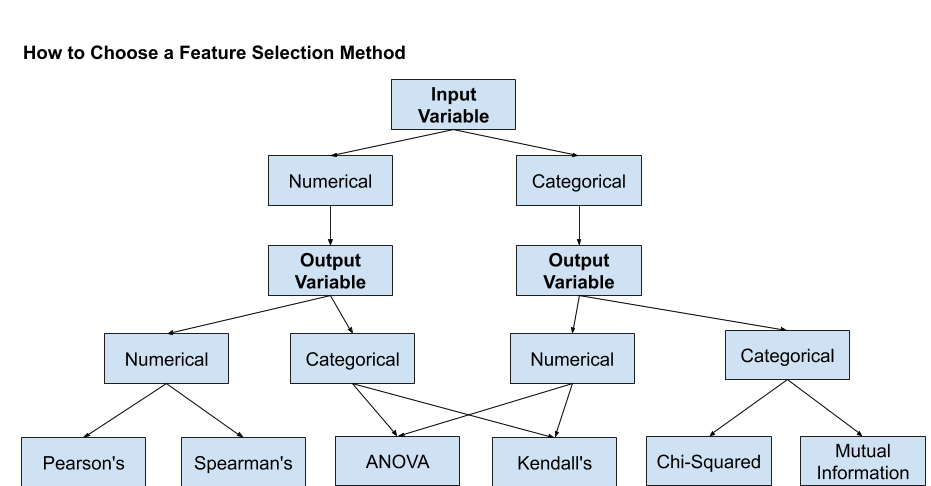

Plot the matrix to find any highly correlated features

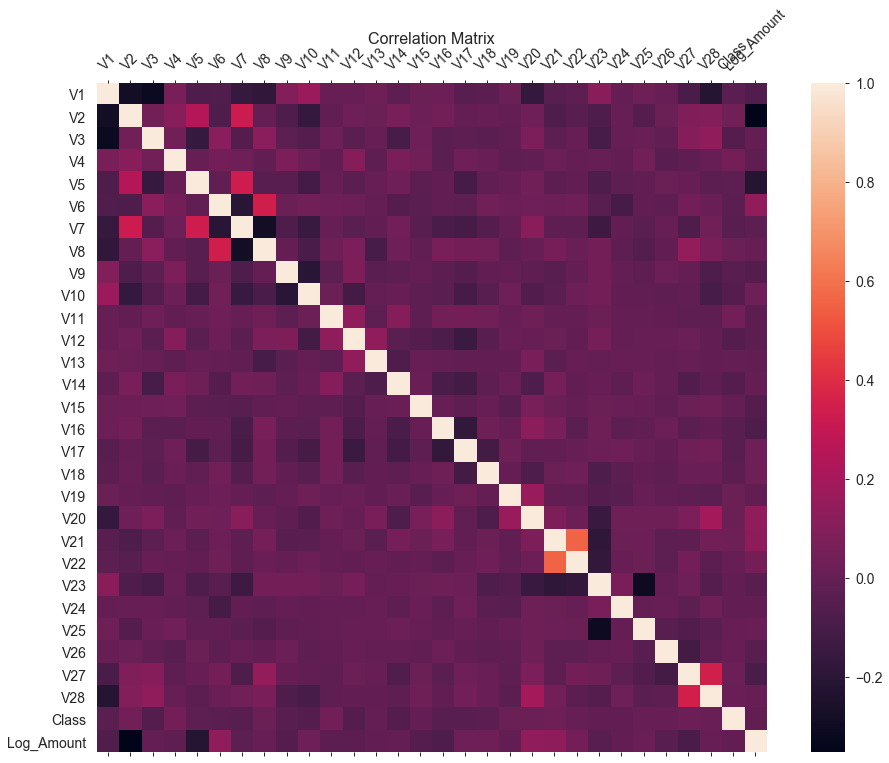

In [11]:
f = plt.figure(figsize=(16, 12))
plt.matshow(df.corr(method='kendall'), fignum=f.number) # pearson or spearman are also available
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [12]:
X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']
OrigPct = CalcPct(y,"Original")

# split the dataset
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
test_size = 0.3
val_size = 0.5

class_names=[0,1]

strat = True
if (strat == True):
    stratify=y['Class']
else:
    stratify="None"
# stratify will ensure that Train, Test and Validation get the same pct of minority classes (.17%)
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = None, shuffle=True, stratify=stratify)
X_train, X_test1, y_train, y_test1 = train_test_split(X,y, test_size = test_size, random_state = None, shuffle=True, stratify=stratify)
# then split Test1 into Test and Validate
# Validate will be used as a final benchmark, once all the parameter tuning is completed
X_test, X_val, y_test, y_val = train_test_split(X_test1,y_test1, test_size = val_size, random_state = None, shuffle=True)

TrainPct = CalcPct(y_train,"Train")
TestPct = CalcPct(y_test,"Train")
ValPct = CalcPct(y_val,"Train")
zeros, ones = np.bincount(y_train['Class'])

Original
[[     0      1]
 [284315    492]]
Train
[[     0      1]
 [199020    344]]
Train
[[    0     1]
 [42636    85]]
Train
[[    0     1]
 [42659    63]]


Look at the distributions compared between 2 variables

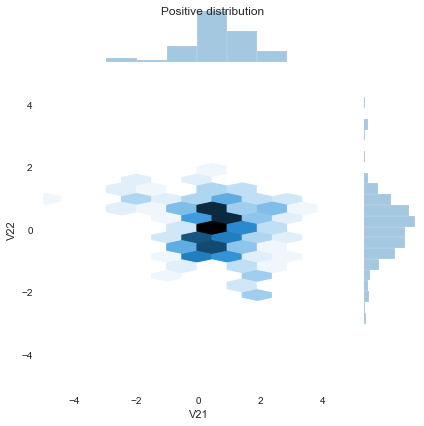

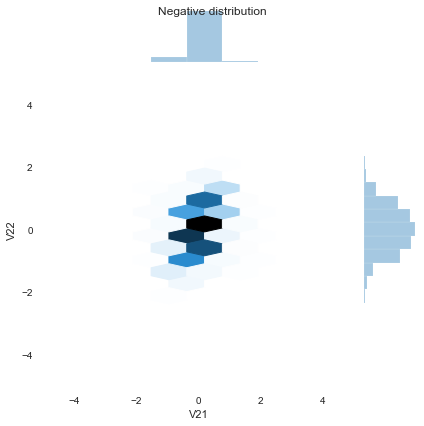

In [13]:
# Form np arrays of labels and features for jointplot charts

train_labels = np.array(y_train).flatten()
bool_train_labels = train_labels != 0 # has an extra ,1 in the bool_train_labels.shape
val_labels = np.array(y_val)
test_labels = np.array(y_test)
train_features = np.array(X_train)
val_features = np.array(X_val)
test_features = np.array(X_test)

pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = X.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = X.columns)
sns.jointplot(pos_df['V21'], pos_df['V22'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")
sns.jointplot(neg_df['V21'], neg_df['V22'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")
plt.show()

In [14]:
# find the number of minority (value=1) samples in our train set so we can down-sample our majority to it
yes = len(y_train[y_train['Class'] ==1])

# retrieve the indices of the minority and majority samples 
yes_ind = y_train[y_train['Class'] == 1].index
no_ind = y_train[y_train['Class'] == 0].index

# random sample the majority indices based on the amount of 
# minority samples
new_no_ind = np.random.choice(no_ind, yes, replace = False)

# merge the two indices together
undersample_ind = np.concatenate([new_no_ind, yes_ind])

# get undersampled dataframe from the merged indices of the train dataset
X_train = X_train.loc[undersample_ind]
y_train = y_train.loc[undersample_ind]

In [15]:
print(X_train)
print(type(X_train))
X_train.to_csv('X_train_pre.csv', sep=',', mode='a', encoding='utf-8', header=True)

              V1        V2        V3        V4        V5        V6        V7  \
253005  2.038994 -0.042528 -3.056462  0.246329  2.945449  3.297981 -0.004833   
222743 -0.498425  0.462490  1.431166 -0.801936  0.094327  0.161838  0.188269   
75110  -0.353205  1.131534  1.191964 -0.141040  0.308785 -0.451992  0.644570   
5859   -0.855679  0.990363  1.959995  1.179823  1.559548  1.803066  0.553224   
260384  1.921093 -0.597515 -0.541895  0.388110 -0.515931 -0.165462 -0.531401   
...          ...       ...       ...       ...       ...       ...       ...   
149600 -5.100256  3.633442 -3.843919  0.183208 -1.183997  1.602139 -3.005953   
154960 -4.517344  2.500224 -4.013928  1.189452 -2.486861 -1.413476 -4.245707   
86155  -2.756007  0.683821 -1.390169  1.501887 -1.165614 -0.131207 -1.478741   
218442 -6.352337 -2.370335 -4.875397  2.335045 -0.809555 -0.413647 -4.082308   
145800 -0.419820 -1.155978 -2.092516  2.786750  0.736297 -0.167292  1.600027   

              V8        V9       V10  .

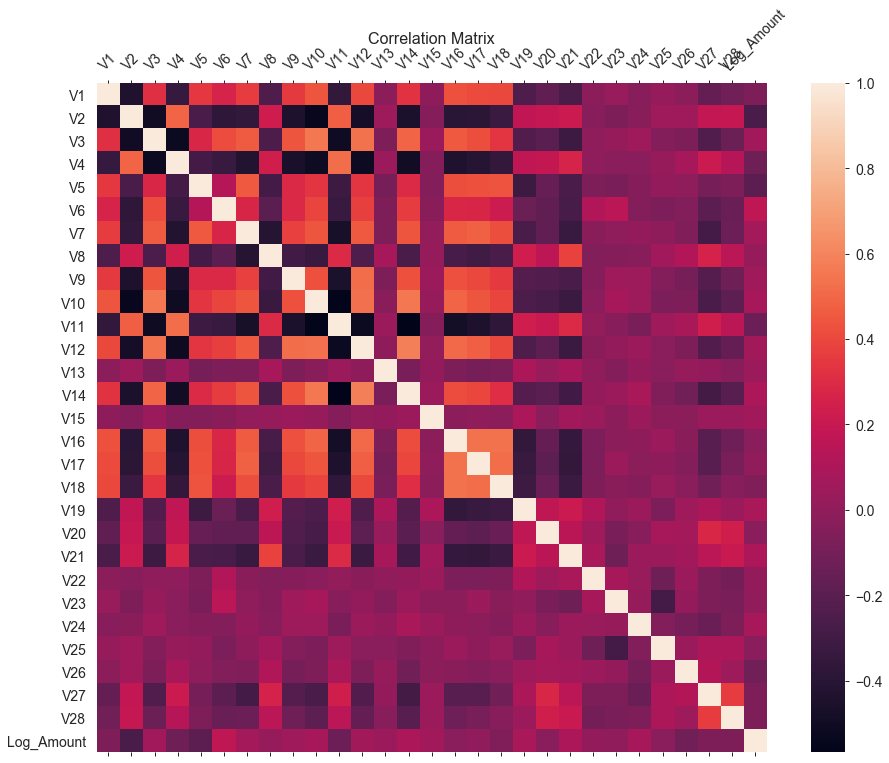

In [16]:
f = plt.figure(figsize=(16, 12))
plt.matshow(X_train.corr(method='kendall'), fignum=f.number) # pearson or spearman are also available
plt.xticks(range(X_train.shape[1]), X_train.columns, fontsize=14, rotation=45)
plt.yticks(range(X_train.shape[1]), X_train.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [17]:
# prepare data for model, need to do this normalization and clipping separately for X_train, X_test and X_val 
# to avoid any contamination between Train and Test/Validate datasets. Also need to keep the order of the rows to match
# the y label dataframes

sc = StandardScaler()

old = '''
# why does this perform better than the new method below? Should be the same....
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)
pd.DataFrame(X_train).to_csv('X_train_old.csv')'''



scaled_features = sc.fit_transform(X_train.values)
X_train = pd.DataFrame(scaled_features, index=X_train.index, columns=X_train.columns)
scaled_features = sc.fit_transform(X_test.values)
X_test = pd.DataFrame(scaled_features, index=X_test.index, columns=X_test.columns)
scaled_features = sc.fit_transform(X_val.values)
X_val = pd.DataFrame(scaled_features, index=X_val.index, columns=X_val.columns)
pd.DataFrame(X_train).to_csv('X_train_new.csv')

a='''
# handle any extreme fliers, set to 5 or -5
X_train = np.clip(X_train, -5, 5)
X_test = np.clip(X_test, -5, 5)
X_val = np.clip(X_val, -5, 5)'''

In [18]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log_Amount
253005,0.789499,-0.440568,0.076774,-0.624073,1.044128,2.197086,0.478336,0.061605,0.588435,0.675251,...,-0.419170,-0.103024,0.175046,0.074339,1.331790,0.700160,-0.999533,-0.089876,-0.228595,-0.946135
222743,0.348359,-0.315021,0.778617,-0.953453,0.389116,0.467093,0.510893,-0.045256,0.654255,0.496755,...,-0.300432,-0.009288,0.746314,-0.142924,-0.661865,-0.510677,1.057780,-0.102906,0.229610,-0.066821
75110,0.373606,-0.148696,0.741207,-0.745790,0.438385,0.128486,0.587823,-0.069039,0.246649,0.534040,...,-0.042047,-0.205891,-0.547322,-0.009656,0.035245,-0.177668,0.115169,0.140951,0.099261,-0.854503
5859,0.286249,-0.183791,0.861323,-0.330756,0.725733,1.372445,0.572422,-0.000728,0.582749,0.599928,...,-0.512514,-0.174061,-0.098845,0.183548,-1.901911,-1.232489,-1.010410,-0.233237,-0.272713,-0.298717
260384,0.769001,-0.578538,0.470040,-0.579524,0.248917,0.286545,0.389559,-0.099621,1.082987,0.603737,...,-0.191596,-0.032738,0.665250,0.032776,-0.878363,-0.184813,1.315593,-0.116571,-0.171381,0.583609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149600,-0.451688,0.473278,-0.046380,-0.643907,0.095436,1.261608,-0.027639,-1.908647,1.132201,-0.199242,...,-2.821436,3.093109,-2.516916,0.815144,-0.181859,0.725663,-1.053106,0.801013,1.086742,1.057943
154960,-0.350346,0.191560,-0.072969,-0.327731,-0.203881,-0.401897,-0.236656,0.186282,1.081031,-0.373217,...,-1.188679,0.396973,0.062749,0.405476,-0.389373,0.185883,0.098132,-1.013464,0.659745,-0.651082
86155,-0.044131,-0.259998,0.337374,-0.229559,0.099660,0.305441,0.229842,-0.133345,0.524124,0.110156,...,-0.303126,0.006726,0.514637,0.171082,-0.781015,-0.246609,2.382491,-1.197146,1.651862,0.717482
218442,-0.669367,-1.019261,-0.207698,0.032231,0.181460,0.149638,-0.209108,0.392179,-0.303257,-0.515517,...,-0.028991,0.396304,1.062314,-0.996360,-2.473479,-0.336482,0.197246,0.769732,-1.456655,0.953862


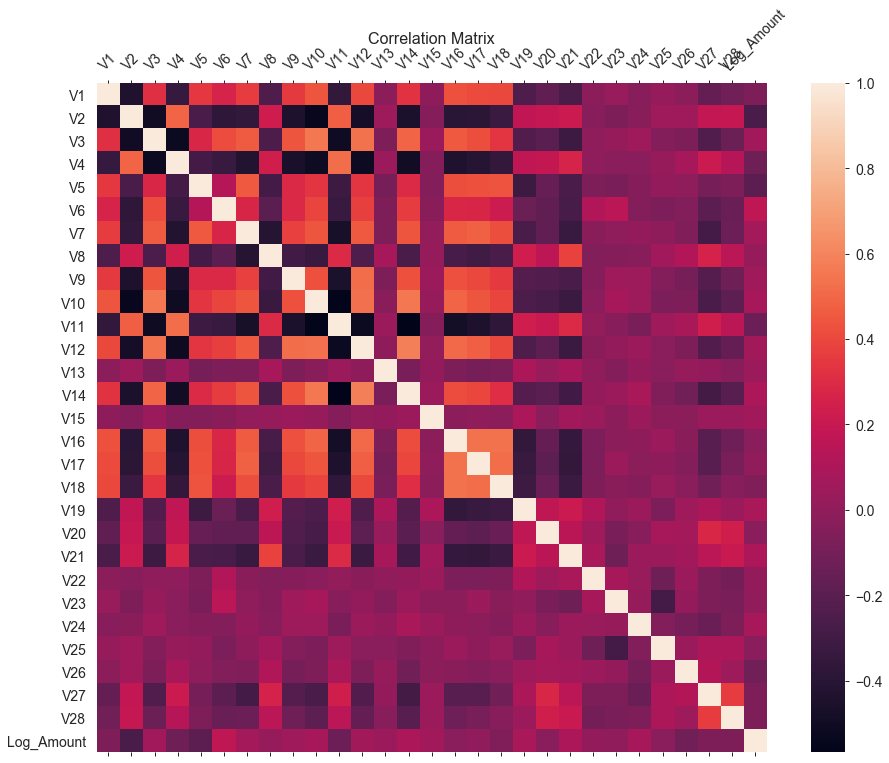

In [19]:
f = plt.figure(figsize=(16, 12))
plt.matshow(pd.DataFrame(X_train).corr(method='kendall'), fignum=f.number) # pearson or spearman are also available
plt.xticks(range(pd.DataFrame(X_train).shape[1]), pd.DataFrame(X_train).columns, fontsize=14, rotation=45)
plt.yticks(range(pd.DataFrame(X_train).shape[1]), pd.DataFrame(X_train).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

Run the Random Forest Classifier model

In [21]:
y_train = np.array(y_train).flatten()
rf = RandomForestClassifier(n_estimators = 1000)

print("Fitting First Draft Model with Train data and default parameters:")
with MyTimer():                            
    rf.fit(X_train, y_train)
    
print(rf.score(X_train, y_train))   

rf.get_params


Fitting First Draft Model with Train data and default parameters:
The function took 6.809554815292358 seconds to complete
1.0


<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

K-Folds cross-validator

Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

Nested versus non-nested cross-validation
This example compares non-nested and nested cross-validation strategies on a classifier of the iris data set. Nested cross-validation (CV) is often used to train a model in which hyperparameters also need to be optimized. Nested CV estimates the generalization error of the underlying model and its (hyper)parameter search. Choosing the parameters that maximize non-nested CV biases the model to the dataset, yielding an overly-optimistic score.

Model selection without nested CV uses the same data to tune model parameters and evaluate model performance. Information may thus “leak” into the model and overfit the data. The magnitude of this effect is primarily dependent on the size of the dataset and the stability of the model. See Cawley and Talbot 1 for an analysis of these issues.

To avoid this problem, nested CV effectively uses a series of train/validation/test set splits. In the inner loop (here executed by GridSearchCV), the score is approximately maximized by fitting a model to each training set, and then directly maximized in selecting (hyper)parameters over the validation set. In the outer loop (here in cross_val_score), generalization error is estimated by averaging test set scores over several dataset splits.

The example below uses a support vector classifier with a non-linear kernel to build a model with optimized hyperparameters by grid search. We compare the performance of non-nested and nested CV strategies by taking the difference between their scores.

In [22]:
param_grid={
    'max_features':[None,'sqrt','log2'],
    # 'max_features': range(50,401,50),
    # 'max_features': [50,100], # can be list or range or other
    #'n_estimators': range(50,126,25), # number of trees
    #'class_weight':['balanced',None],
    #'max_samples':[0.2,0.4,0.6,0.8],
    #'max_features':[None,'sqrt','log2'],   
    #'min_samples_leaf': range(10,40,10),
    #'min_samples_split': range(20,80,10),
    'criterion':['gini','entropy']
}

# Number of random trials to use for KFold Strategy
NUM_TRIALS = 2

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # To be used within GridSearch 
    inner_cv = KFold(n_splits=2, shuffle=True, random_state=None)

    # To be used in outer CV 
    outer_cv = KFold(n_splits=2, shuffle=True, random_state=None)    
    
    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='roc_auc', # or 'r2', etc
        #scoring='neg_mean_squared_error', # or look here for other choices 
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        #cv=5,
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=verbose
    )

    print("Running GridSearchCV:")
    with MyTimer():    
        grid_result = gsc.fit(X_train, y_train)   
    non_nested_scores[i] = grid_result.best_score_
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # nested/non-nested cross validation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
    with MyTimer():    
        nested_score = cross_val_score(gsc, X=X_train, y=y_train, cv=outer_cv, verbose=verbose).mean() 
        # source code for cross_val_score is here: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_validation.py#L137
    print("nested score from KFold")
    print(nested_score)
    nested_scores[i] = nested_score

if (verbose == 1):
    #for test_mean, train_mean, param in zip(
    for test_mean, param in zip(
            grid_result.cv_results_['mean_test_score'],
            #grid_result.cv_results_['mean_train_score'],
            grid_result.cv_results_['params']):
        print("Test : %f with: %r" % (test_mean, param))

score_difference = non_nested_scores - nested_scores

print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))



Running GridSearchCV:
The function took 106.01611638069153 seconds to complete
Best: 0.983053 using {'criterion': 'entropy', 'max_features': 'sqrt'}
The function took 246.72333908081055 seconds to complete
nested score from KFold
0.9800476625088732
Running GridSearchCV:
The function took 140.61631512641907 seconds to complete
Best: 0.980764 using {'criterion': 'entropy', 'max_features': 'sqrt'}
The function took 178.67560744285583 seconds to complete
nested score from KFold
0.9808011096451166
Average difference of 0.001484 with std. dev. of 0.001521.


In [23]:
wt1 = 1.0
wt0 = 1.0
# create your optimized best model using the best params from CV  
rf = RandomForestClassifier(**grid_result.best_params_)

# fit the model you created with the best settings earlier
print("Fitting Model (Train) with GridSearch and Cross Validation optimized params:")
#rf.fit(X_train, y_train)
rf.fit(X_train, y_train, sample_weight=np.where(y_train == 1, wt1, wt0).flatten())

print("Train rf.score")
print(rf.score(X_train, y_train))


Fitting Model (Train) with GridSearch and Cross Validation optimized params:
Train rf.score
1.0


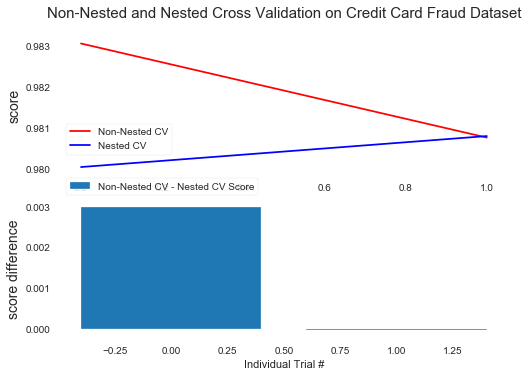

In [24]:
# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation on Credit Card Fraud Dataset",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

plt.show()

In [25]:
print("True Model Score from Test Data:")
print(rf.score(X_test, y_test))

True Model Score from Test Data:
0.9796821235457972


Validate the grid parameters used in my model

In [26]:
grid_result

GridSearchCV(cv=KFold(n_splits=2, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=1000, n_jobs=None,
                                              oob_s

Show the results of the GridSearchCV function

In [27]:
# show results of the GridSearch
print('wt1', 'wt0')
print(wt1, wt0)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

wt1 wt0
1.0 1.0
Best: 0.980764 using {'criterion': 'entropy', 'max_features': 'sqrt'}


Use this model to predict the Test and Validate datasets

Test Data results
0.9796821235457972
Accuracy score (training): 1.000
Accuracy score (validation): 0.980
error
Confusion Matrix:
false positive pct: 2.0200837995365277
tn  fp  fn  tp
41792 863 5 61
[[41792   863]
 [    5    61]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     42655
           1       0.07      0.92      0.12        66

    accuracy                           0.98     42721
   macro avg       0.53      0.95      0.56     42721
weighted avg       1.00      0.98      0.99     42721

Specificity = 0.9797679052866018
Sensitivity = 0.9242424242424242


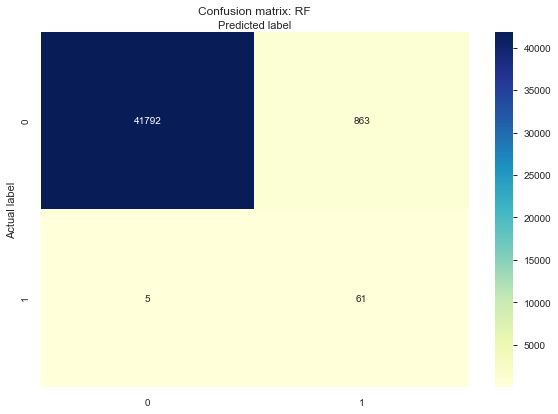

  No Skill : ROC AUC=0.500
        RF : ROC AUC=0.973


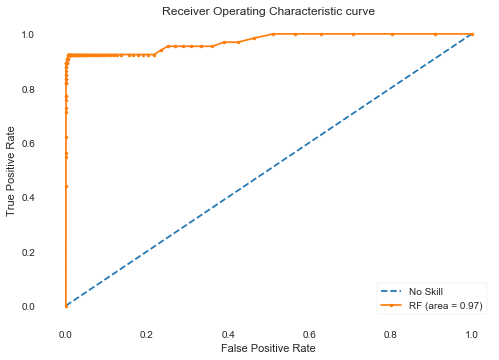

rf_auc 0.9728

Val Data results
0.9815551706380787
Accuracy score (training): 1.000
Accuracy score (validation): 0.982
error
Confusion Matrix:
false positive pct: 1.8257572211038808
tn  fp  fn  tp
41860 780 8 74
[[41860   780]
 [    8    74]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     42640
           1       0.09      0.90      0.16        82

    accuracy                           0.98     42722
   macro avg       0.54      0.94      0.57     42722
weighted avg       1.00      0.98      0.99     42722

Specificity = 0.9817073170731707
Sensitivity = 0.9024390243902439


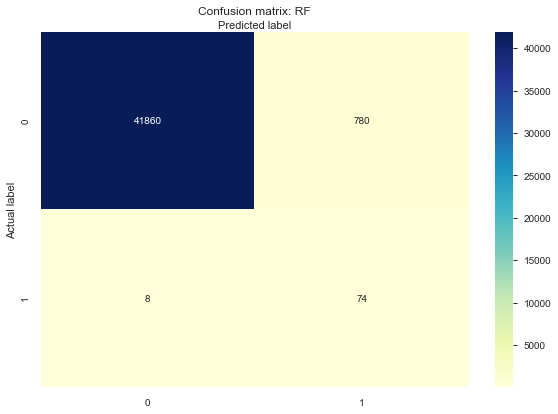

  No Skill : ROC AUC=0.500
        RF : ROC AUC=0.972


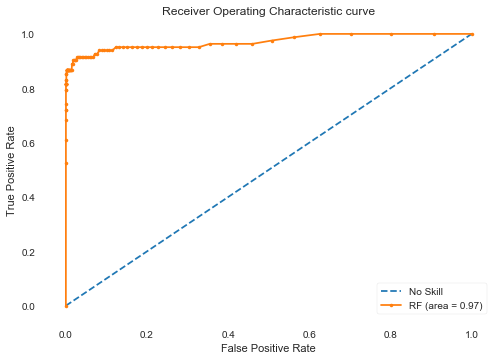

rf_auc 0.9719


In [28]:
# use this model to predict a new dataset
rf_Pred=rf.predict(X_test)

#print(metrics.accuracy_score(y_test, y_pred))
#print(classification_report(y_test, rf_Pred))
print("Test Data results")
tn, fp, fn, tp = display_metrics(rf, X_train, X_test, y_train, y_test, rf_Pred)

visualize(y_test, rf_Pred, 'RF')

rf_auc = auc_roc_metrics(rf, X_test, y_test, 'RF')
print('rf_auc', rf_auc)

# use this model to predict a new dataset
rf_Pred=rf.predict(X_val)

#print(metrics.accuracy_score(y_val, y_pred))
#print(classification_report(y_val, rf_Pred))
print("\nVal Data results")
tn, fp, fn, tp = display_metrics(rf, X_train, X_val, y_train, y_val, rf_Pred)

visualize(y_val, rf_Pred, 'RF')

rf_auc = auc_roc_metrics(rf, X_val, y_val, 'RF')
print('rf_auc', rf_auc)

In [29]:
print(datetime.datetime.now())

2020-06-22 00:16:26.359148
